<a href="https://colab.research.google.com/github/jungihong10/age_recognition/blob/main/Age_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recently, many applications from biometrics,to entertainment use the information extracted from face images that contain information about age, gender, ethnic background, and emotional state. Automatic age estimation from facial images is one of the popular and challenging tasks that have different fields of applications such as controlling the content of the watched media depending on the customer's age.
So facial feature analysis has been a topic of interest mainly due to its applicability and Deep Learning techniques are now making it possible for face analysis to be not just a dream but a reality. This simple practice dataset can get you more acquainted with application of deep learning in age detection.



Indian Movie Face database (IMFDB) is a large unconstrained face database consisting of 34512 images of 100 Indian actors collected from more than 100 videos. All the images are manually selected and cropped from the video frames resulting in a high degree of variability interms of scale, pose, expression, illumination, age, resolution, occlusion, and makeup. IMFDB is the first face database that provides a detailed annotation of every image in terms of age, pose, gender, expression and type of occlusion that may help other face related applications.

The dataset provided a total of 19906 images.The attributes of data are as follows:

ID – Unique ID of image
Class – Age bin of person in image


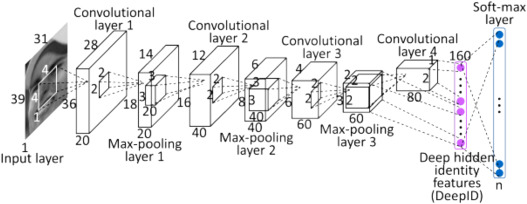

image ref : Automatic age estimation based on CNN

The main task is to predict the age of a person from his or her facial attributes. For simplicity, the problem has been converted to a multiclass problem with classes as Young, Middle and Old.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# read the csv file to check out the images and class
data = pd.read_csv("/train.csv")
data.head()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=ebee02ad42bbd420c7de7b3d280f25b4048e6011a8b6d1731b07c6f66a79a99b
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
data['Class'].replace(['YOUNG','MIDDLE','OLD'],[0,1,2],inplace=True)
data.head(3)

In [ ]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [ ]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [ ]:
# built the list of image paths and list of respective responses of the images
PATH = "/kaggle/input/faces-age-detection-dataset/Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = data.loc[data['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))

In [ ]:
# split the dataset into train and test dataset
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

In [ ]:

train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# build the layers of CNN model
from tensorflow.keras import layers,models

cnn_model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding = 'same'),
    layers.MaxPooling2D((2, 2)),
    
    # layers.BatchNormalization(),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    layers.MaxPooling2D((2, 2)),

    # layers.BatchNormalization(),
    
    # layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    # layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    # layers.Dropout(0.25),
    layers.Dense(3, activation='softmax')
])

In [ ]:
# view the summary of the cnn model
cnn_model.summary()

In [ ]:
# compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# fit the model
cnn_model.fit(train_set, epochs=10, validation_data=test_set)

In [ ]:
cnn_model.evaluate(train_set)

In [ ]:
# test accuracy
cnn_model.evaluate(test_set)

In [ ]:
test_pred = cnn_model.predict(test_set)

In [ ]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])


In [ ]:
class_names = ['YOUNG','MIDDLE','OLD']

In [ ]:
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

In [ ]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix, without normalization')

In [ ]:
# plotting confusion matrix with normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')